# Introduction to Data Science

Propomos utilizar **Polaridade-Subjetividade**, junto a **Presença-Ausência** de um conjunto de temas em cada Tweet como parte dos preditores; junto a isso, a **Contagem Diária**, **Contagem de Retweets**, **Contagem de Favoritos**, **Data e Horário**, **Presença de Mídias ou Citações**, por exemplo.

Propomos ainda usar um fator de retardo $k$ para caracterizar a influencia retardada das postagens. Caso o ajuste significativo ocorra sob um fator $k \neq 0$, isto é, caso alterções relevantes sejam observadas após as postagens, e com coeficientes significativos, podemos discutir a influencia dos tweets como possível; caso o retardo seja nulo, ou pequeno, podemos discutir a exiestencia de correlação sem causalidade.

Ao tratar de séries temporais envolvendo dados financeiros, comumente tratamos a ifluencia de preditores sobre a variação relativa do dados; para isso buscamos predizer os *log-retornos* das variáveis econômicas escolhidas.

**Referencias Utilizadas**:
  * **Constantin Colonescu**. The Effects of Donald Trump’s Tweets on US Financial and Foreign Exchange Markets. Athens Journal of Business and Economics. Disponível em: www.athensjournals.gr/business/2018-1-X-Y-Colonescu.pdf

In [18]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

%matplotlib inline

## Preparação dos dados

Inclui as etapas de standandização, separação, e agregação segundo diferentes métodos: sob certas hipóteses, podemos agregar os tweets diários pela média, sentimentos extremos, tweet mais curtido ou repostado. Isto é: agregamos diariamente os tweets sob certo método. Considerar o tweet mais repostado, por exemplo, faz sentido sob a suposção de que este será o mais relevante do dia.

In [2]:
# read the data
tweets_data = pd.read_pickle("data/final_tweets_data.pkl")
tweets_data = tweets_data.drop(["full_text", "full_text_en"], axis=1)
economic_data = pd.read_csv("data/economic_time_series.csv", sep=";", index_col=0)

# chose features and responses
responses = ['selic_meta', 'international_reserve','cdi','dollar']
economic_data = economic_data[responses]

# chose only Bolsonaro tweeter
tweets_data = tweets_data[tweets_data.name == "jairbolsonaro"]

Usamos um formato padrão de datas e ajustamos as séries temporais.

In [3]:
# use standard date format "datetime"
economic_data.index = pd.to_datetime(economic_data.index)

tweets_data["date"]  = tweets_data.year.apply(str) + "-"
tweets_data["date"] += tweets_data.month.apply(str) + "-"
tweets_data["date"] += tweets_data.day.apply(str)
tweets_data["date"]  = pd.to_datetime(tweets_data["date"])

Adicionamos algumas *dummy-variables* convertendo um conjunto de variáveis qualitativas dos preditores em colunas numéricas.

Para primeira análise, agregamos alguns dados com relação ao tweet mais favoritado, tomando por hipótese que este será o mais relevante naquele dia. Adicionamos, ainda, novas tabelas agragando o total de retweets do dia, assim como polaridade e subjetividade médias, por exemplo:

In [4]:
# select by data type wich to be made dummy
cols_to_strd = ["user_mentions", "hashtags"]
cols_to_dumm = ["media_type", "name", "topic", "weekday",
                "year", "month", "day", "hour", "minute"]

# add dummies 
for col in cols_to_dumm:
  dummies = pd.get_dummies(tweets_data[col], prefix=col, drop_first=True)
  tweets_dayly = pd.concat([tweets_data.drop(col, axis=1), dummies], axis=1)

for col in cols_to_strd:
  dummies = tweets_data[col].str.get_dummies("/").add_prefix(col)
  tweets_dayly = pd.concat([tweets_data.drop(col, axis=1), dummies], axis=1)

# agregate the data using mean
tweets_dayly = tweets_data.groupby("date", as_index=True).mean()

Ajustamos as séries temporais no mesmo período de tempo e expressamos os Dados Economicos no formato de log-retornos; esse formato é útil quando estamos interessados no estudo da variação de dados econômicos, por se mostrar uma variável relativa. Isso significa que deve ser possível observar impactos.

Finalmente, separamos os dados de treino e teste. Por simplicidade, renomeamos os dados para DTw_train, DTw_test (DTw - Dayly Tweets). Para primeira apresentação, buscamos regredir um simples modelo para o **DOLAR**, em EILR_train, EILR_test (EILR - Economic Index Log Return)
; posteriormente, as mesmas tecnicas apresentadas serão utilizadas na discussão dos demais dados.

In [5]:
# and express it as a log-return index
economic_data_lr = np.log(1 + economic_data.dropna().pct_change())

# put tempotal series together
data = pd.concat([economic_data_lr, tweets_dayly], axis=1).dropna()

In [6]:
predictors = tweets_dayly.columns

# chose a response economic index as example
response = "dollar"
EILR_data = data[response]
DTw_data = data[predictors]

# separate train and test data
data_train, data_test = train_test_split(data)
EILR_train, EILR_test = data_train[response], data_test[response]
DTw_train, DTw_test = data_train[predictors], data_test[predictors]

# normalize preditors
normalizer = Normalizer().fit(DTw_train)
DTw_train = pd.DataFrame(normalizer.transform(DTw_train), columns=predictors)
DTw_test = pd.DataFrame(normalizer.transform(DTw_test), columns=predictors)
DTw_data = pd.DataFrame(normalizer.transform(DTw_test), columns=predictors)

## Visualização dos dados: PCA e Sentimento/Reercussão

Buscamos relacionar as principais compenentes com os dados economicos em primeira intancia

Variancia explicada:  0.9999842078172774


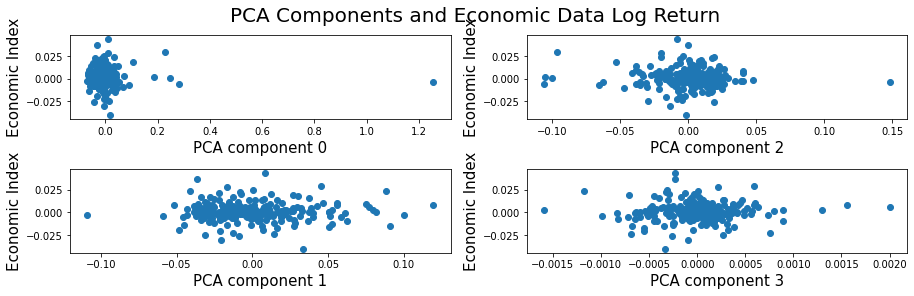

In [7]:
transformer = PCA(4).fit(DTw_train)
print("Variancia explicada: ", np.sum(transformer.explained_variance_ratio_))

DTw_train_4d = pd.DataFrame(transformer.transform(DTw_train), columns=[0,1,2,3])
DTw_test_4d = pd.DataFrame(transformer.transform(DTw_test), columns=[0,1,2,3])
DTw_data_4d = pd.DataFrame(transformer.transform(DTw_data), columns=[0,1,2,3])

fig, ax = plt.subplots(2,2,figsize=(15,4))

for i in range(2):
  for j in range(2):
    ax[i][j].scatter(DTw_train_4d[i+j*2], EILR_train)
    ax[i][j].set_xlabel("PCA component {}".format(i+j*2), fontsize=15)
    ax[i][j].set_ylabel("Economic Index", fontsize=15)

fig.suptitle("PCA Components and Economic Data Log Return", fontsize=20)
fig.subplots_adjust(hspace=0.6)
plt.show()

Apenas quatro (4) componentes principais dos dados normalizados mostraram explicar mais de 99% da variância dos preditores; no entanto, os gráficos mostram que esse fato não é suficiente: a massa principal de dados aparenta ser fracamente dependente, e se comportam sob uma reta horiontal.

Abaixo, visualizamos a os preditores mais intuitivos, escolhidos com base no modelo da referencia.

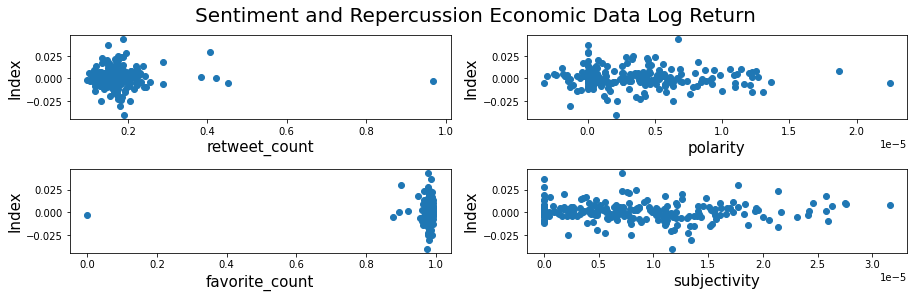

In [8]:
# predictors to be considered
sr_predictors = ["retweet_count", "favorite_count", "polarity", "subjectivity"]

# dayly index
fig, ax = plt.subplots(2,2,figsize=(15,4))
for i in range(2):
  for j in range(2):
    col = sr_predictors[i + 2*j]
    ax[i][j].scatter(DTw_train[col], EILR_train)
    ax[i][j].set_xlabel(col, fontsize=15)
    ax[i][j].set_ylabel("Index", fontsize=15)

fig.suptitle("Sentiment and Repercussion Economic Data Log Return", fontsize=20)
fig.subplots_adjust(hspace=0.6)
plt.show()

Novamente, os dados não parecem romissores no ajuste de uma modelo polinomial para regressão. Veremos como essa intuição é explicada pela análise posterior.

## Ajuste de Modelos, Regularização e *Cross-Validation*

Com base no observado anteriormente, buscamos ajustar algumas propostas distintas:
 
  1. Ajustamos um modelo utilizando todos os preditores normalizados utilizando Lasso. Uma vez que queremos um modelo mais simple, é vantajoso favorecer a eliminação de parâmetros em excesso.
  2. Ajustamos um modelo utilizando apenas 4 componentes de PCA apresentadas anteriormente.
  3. Ajustamos um modelo considerando apenas *sentimento* e *repercussão*, com base na referencia. Aqui, damos preferencia ao modelo regularizado por Ridge, favorecendo manter coeficientes mesmo pouco expressivos.


### Regressão Utilizando todos os Preditores (não-correlacionados)

In [9]:
# remove strongly correlated columns
corr_mat = DTw_train.corr().abs()
corr_upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
to_drop = [col for col in corr_upper.columns if any(corr_upper[col] > 0.85)]

DTw_train_decorr = DTw_train.drop(to_drop, axis = 1)
DTw_test_decorr = DTw_test.drop(to_drop, axis = 1)

# regularization hiperparameters
lambdas = np.logspace(-1,4,30)
best_model = LassoCV().fit(DTw_train_decorr, EILR_train)

# scores for train and test
score_train = best_model.score(DTw_train_decorr, EILR_train)
score_test = best_model.score(DTw_test_decorr, EILR_test)

print("Scores", "\ntrain: {}".format(score_train), "\ntest: {}".format(score_test))

Scores 
train: 0.0 
test: -0.000633489075324789


Obtivemos resultados claramente pouco expressivos. Em média, o modelo utilizado atinge apenas a mesma erfoórmance d o modelo mais simples, utilizando a média dos log-retornos.

### Regressão utilizando PCA

Utilizamos o método bastante semelhante ao anterior, mas neste ponto, interessados em usar apenas quatro preditores obtidos por PCA; estes já não-correlacionados.

In [10]:
# regularization hiperparameters
lambdas = np.logspace(-1,4,30)
best_model = RidgeCV(alphas=lambdas).fit(DTw_train_4d, EILR_train)


# scores for train and test
score_train = best_model.score(DTw_train_4d, EILR_train)
score_test = best_model.score(DTw_test_4d, EILR_test)

print("Scores", "\ntrain: {}".format(score_train), "\ntest: {}".format(score_test))
print("Coefficients: ", best_model.coef_)

Scores 
train: 8.87884817890594e-08 
test: -0.0006335192599631334
Coefficients:  [-3.39430107e-08  3.02731265e-08 -3.29925494e-07  3.77497675e-09]


### Modelo Linear Utilizando *Sentimento* e *Repercussão*

Consideramos apenas parâmetros mais simples, relacionados ao sentimento (*Polaridade* e *Positividade*) e popularidade dos tweets (*Contagem de Favoritos* e *Contagem de Retweets*). Novamente, buscamos um simples modelo linear, com base na referencia citada, e na análise exploratória.

In [11]:
# chose Sentimental and Repercution as predictors
DTw_train_sr = DTw_train[sr_predictors]
DTw_test_sr = DTw_test[sr_predictors]

# remove strongly correlated columns
corr_mat = DTw_train_sr.corr().abs()
corr_upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
to_drop = [col for col in corr_upper.columns if any(corr_upper[col] > 0.85)]

DTw_train_decorr = DTw_train_sr.drop(to_drop, axis = 1)
DTw_test_decorr = DTw_test_sr.drop(to_drop, axis = 1)

# regularization hiperparameters
lambdas = np.logspace(-1,4,30)
best_model = RidgeCV(alphas=lambdas).fit(DTw_train_decorr, EILR_train)

# scores for train and test
score_train = best_model.score(DTw_train_decorr, EILR_train)
score_test = best_model.score(DTw_test_decorr, EILR_test)

print("Scores", "train {}".format(score_train), "test {}".format(score_test))
print("Coefficients: ", best_model.coef_)

Scores train 3.4179623797925274e-08 test -0.0006335080893811185
Coefficients:  [ 2.06645843e-07 -4.84404129e-11 -9.95585478e-11]


Obtivemos coeficientes pouco significativos em primeira análise, em comparação com o obtido em PCA, especialmente para os dados relacionaods a popularidade das postagens, em que obtivemos coeficientes desprezíveis; ao mesmo tempo, o modelo apresenta um ajuste ruim aos dados de treino. Esse fato deverá ser discutido logo mais.

### Modelo com PCA utilizando retardo

Discutimos um último modelo, em que utilizamos as *features* mais promissoras, adicionando retardo, como proposto inicialmente. Os resultados para tentativas utilzando o mesmo método de regressão linear anterior com retardo $k \in \{0,...,30\}$ dias são apresentados logo  mais.


In [12]:
# function to delay predictor in days 
def add_delay(X, y, X_comp, y_comp, delay):
  """
  canges indexes by delay in days
    X_, y_: data to be delayed
    X_comp, y_comp: complete data
    delay: time in days to be delayed
  """
  indexes = [i for i in X.index - delay if i in X_comp.index]
  X_ = X_comp.iloc[indexes].dropna()
  y_ = y[(X.index - delay).isin(indexes)]

  return X_, y_

In [13]:
# Chose best polynomial degree
def chose_degree(X_train, y_train, lambdas, max_poly_degre):
  """
  Chose best polynomial degree using mean score
    X_train, y_train: train data to be used in adjust
    max_poly_degre: max polynomial degree to be used
  """
  best_score = -1000; best_degree = 0
  
  # polynomial features
  for k in range(1, max_poly_degre + 1):
    X_poly = PolynomialFeatures(k).fit_transform(X_train)
    best_model = RidgeCV(alphas=lambdas).fit(X_train, y_train)
    score = best_model.score(X_train, y_train)
    
    if score > best_score:
      best_score = score; best_degree = k

  return best_degree

In [14]:
# regression function to ajust polynomial models
def pca_poly_delay_adjust(X_train, y_train, X_test, y_test,
                          X_data, y_data, lambdas, N_days, max_poly_degre):
  """
  Adjusts a series of models and 
    X_train, y_train: train data
    X_test, y_test: test data
    X_data, y_data: complete data to use in delay
    lambdas:  regularization hiperparameters
    N_days: number of days to adjust delay models
    max_poly_degre: max polynomial degree to use
  """

  # dictionary with delays results
  results = []

  # adjusts models to data with delays 
  for delay in range(N_days):
    # adds delay
    X_train_, y_train_ = add_delay(X_train, y_train, X_data, y_data, delay)
    X_test_, y_test_ = add_delay(X_test, y_test, X_data, y_data, delay)

    # regularization
    best_degree = chose_degree(X_train_, y_train_, lambdas, max_poly_degre)
    
    # adjusts model and evals scores obtained with best model
    X_train_poly = PolynomialFeatures(best_degree).fit_transform(X_train_)
    best_model = RidgeCV(alphas=lambdas).fit(X_train_poly, y_train_)

    score_train = best_model.score(X_train_poly, y_train_)
    X_test_poly = PolynomialFeatures(best_degree).fit_transform(X_test_)
    score_test = best_model.score(X_test_poly, y_test_)
 
    results.append({"delay": delay, "train": score_train,
                    "test": score_test, "degree": best_degree})
  
  return results

Abaixo, executamos a função responsável por ajustar um modelo polinomial utilizanado PCA, com base no melhor resultado obtido nos modelos anteriores. O algoritmo busca pela melhor cobinação entre coeficiente de regularização e grau polinomial utilizando *cross-validation*, introduzindo retardo.

In [15]:
# apply function
lambdas = np.logspace(-1,4,30)
results = pca_poly_delay_adjust(DTw_train_4d, EILR_train, DTw_test_4d,
                                EILR_test, DTw_data_4d, EILR_data, lambdas, 30, 3)

# look at the four best results in train
results = pd.DataFrame(results)
results["response"] = "Dolar"
results.sort_values(by = "train", ascending=False).head()

,delay,train,test,degree,response
6,6,0.036832,0.006322,1,Dolar
18,18,0.036267,0.044895,1,Dolar
21,21,0.034306,-0.057057,1,Dolar
7,7,0.001337,0.000336,1,Dolar
10,10,0.001237,-0.002502,1,Dolar


Os testes mostraram dificudade em prever com razoavel precisão os dados reais do mercado com base apenas nos Tweeters da Família presidencial; de fato, os resultados dos diferentes modelos propostos é tão significante quanto o uso da média global dos log-retornos, isto é, não obtiveram perfórmance suficente para justificálos!

## Resultados

Finalmente, após propor o modelo mais geral acima, analizamos os resultados com os demais indicadores; para cada, apresentamos os 4 melhores resultados obtidos.

In [16]:
# response variables to be tested
responses = ['selic_meta','international_reserve','cdi','dollar']

# iterate response variables and collects the results
all_results = []

for response in responses:
  y = data[response]
  y_train = data_train.iloc[DTw_train_4d.index]
  y_test = data_test.iloc[DTw_test_4d.index]
  X = DTw_data_4d
  X_train = DTw_train_4d
  X_test = DTw_test_4d
  

  results = pca_poly_delay_adjust(X_train, y_train, X_test, y_test, X, y, lambdas, 30, 3)
  for i in range(len(results)): results[i]["response"] = response
  results.sort(key = lambda x: x["test"], reverse=True)

  all_results = np.append(all_results, results[0:4])

Apresentamos os melhores resultados para as variáveis de resposta escolhidas. Embora sejam os melhors, ainda é notável como são pouco representativos.

In [17]:
results_table = pd.DataFrame(list(all_results))
results_table.set_index("response")

,delay,train,test,degree
response,,,,
selic_meta,24,3.597577e-07,-0.000764,1
selic_meta,23,7.945337e-08,-0.000783,1
selic_meta,22,3.368667e-08,-0.000944,1
selic_meta,25,5.602821e-07,-0.003876,1
international_reserve,24,3.597577e-07,-0.000764,1
international_reserve,23,7.945337e-08,-0.000783,1
international_reserve,22,3.368667e-08,-0.000944,1
international_reserve,25,5.602821e-07,-0.003876,1
cdi,24,3.597577e-07,-0.000764,1


Portanto, observamos que pode ser extremamente difíci apresentar um modelo capaz de prever, ou ter um ajuste razoável aos retornos dos indicadores economicos apresentados até então utilizando apenas os dados de Tweeter da família do presidente.

Nesse sentido, apresentaoms uma proposta com a hipótese enfraquecida. Embora não possamos prever a magnitude das variações dos índies do mercado, talvez seja possível predizer o aumento ou queda correlacionada aos tweets da família bolsonaro utilizando um modelo de classificação.
